In [180]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [181]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-09-20 17:22:24,308: Credentials are already in use. The existing account in the session will be replaced.


In [182]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [183]:
numLayer = 5
numQubit = 2
global iterations
global noisy

In [184]:
#Create unitaries here
#unitary_param_1 = np.array([])
#for i in range(0, 16):
#    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [0.83414377, 2.27238264, 5.8389326, 2.40918277, 4.47052641, 6.22458201, 1.97847354,
                   1.89334833, 1.88614517, 4.82507852, 2.66745336, 1.38371607, 2.76324645, 3.93540582,
                   0.71193782, 2.74935022]

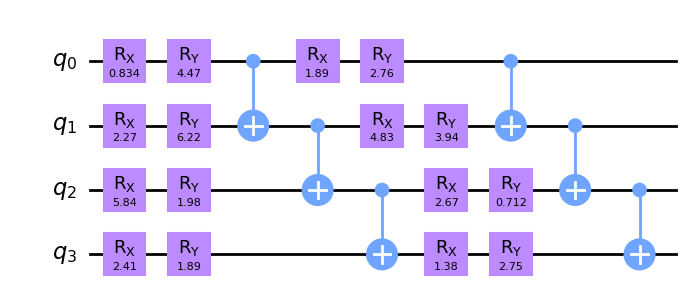

In [69]:
# First unitary
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

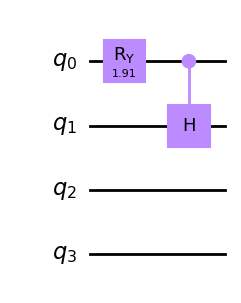

In [162]:
qcTest = QuantumCircuit(4)
qcTest.ry(2*np.arcsin(np.sqrt(2/3)), 0)
qcTest.ch(0, 1)
qcTest.draw('mpl')

In [163]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [164]:
def createEqSuperposCS3():
    temp = QuantumCircuit(2)
    temp.ry(2*np.arctan(np.sqrt(2)), 1)
    temp.ch(1, 0)
    return temp

In [165]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(6)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCS3()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3, 4, 5])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [4, 5])
    
    circ.ccx(0, 3, 2)
    circ.ccx(0, 5, 4)

    circ.ccx(0, 2, 3)
    circ.ccx(0, 4, 5)
    
    circ.ccx(1, 3, 2)
    circ.ccx(1, 5, 4)
    
    circ.ccx(1, 2, 3)
    circ.ccx(1, 4, 5)
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

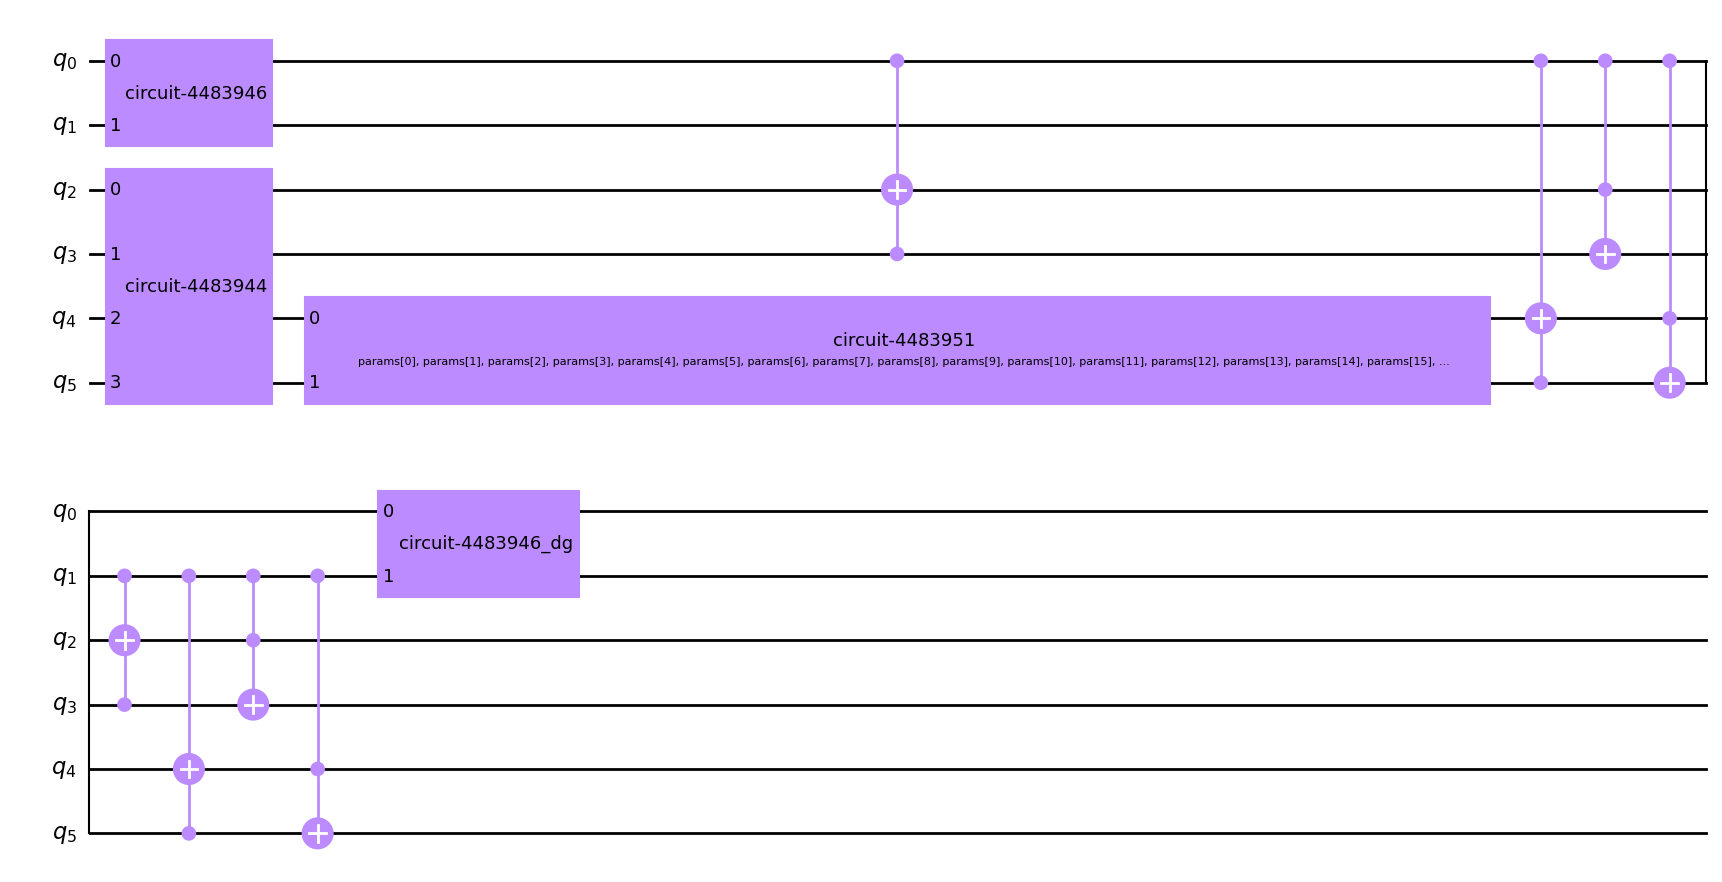

In [166]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [167]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [168]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [169]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [170]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [171]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [172]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19])])


In [173]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [174]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[2.31244117 0.60463551 5.11889996 3.44894859 5.89600882 1.1380356
 2.89356261 4.79335828 2.26345928 0.98681788 0.247192   3.584952
 3.97420983 3.25061203 2.28556569 5.29524341 3.81368364 2.1279575
 5.47026308 0.53876613]
Initial Cost :  0.3680942122462477


In [175]:
true_value = 0.7777

In [176]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.3680942122462477
Loss Value :  0.5317599529392242 1.0%
Loss Value :  0.6923193969018583 2.0%
Loss Value :  0.6297649041491111 3.0%
Loss Value :  0.6130097488018541 4.0%
Loss Value :  0.6177241305908335 5.0%
Loss Value :  0.6854846363816692 6.0%
Loss Value :  0.7286666546691805 7.0%
Loss Value :  0.7284124044773024 8.0%
Loss Value :  0.7379305639923028 9.0%
Loss Value :  0.740713656716709 10.0%
Loss Value :  0.7505007733029475 11.0%
Loss Value :  0.7619552563896074 12.0%
Loss Value :  0.7630718281474204 13.0%
Loss Value :  0.7633852104060093 14.0%
Loss Value :  0.7633203418883621 15.0%
Loss Value :  0.7631761407209209 16.0%
Loss Value :  0.7650910627981131 17.0%
Loss Value :  0.7648714738006923 18.0%
Loss Value :  0.7665600071986844 19.0%
Loss Value :  0.7664751146938285 20.0%
Loss Value :  0.7582108701416584 21.0%
Loss Value :  0.7593363625925176 22.0%
Loss Value :  0.7592324734362124 23.0%
Loss Value :  0.767592906871709 24.0%
Loss Value :  0.7773447710655188 25.0%
L

In [177]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.3524870529829806
Loss Value :  0.45750461570377354 1.0%
Loss Value :  0.44758595167225046 2.0%
Loss Value :  0.4535660732859616 3.0%
Loss Value :  0.46294108606163276 4.0%
Loss Value :  0.4770492001883787 5.0%
Loss Value :  0.5211298382575211 6.0%
Loss Value :  0.4943653081910908 7.0%
Loss Value :  0.5308053734012642 8.0%
Loss Value :  0.53068696229881 9.0%
Loss Value :  0.5413845139299442 10.0%
Loss Value :  0.5327633820080189 11.0%
Loss Value :  0.531414415019113 12.0%
Loss Value :  0.5207317041494104 13.0%
Loss Value :  0.5586383746879028 14.0%
Loss Value :  0.5350015196343704 15.0%
Loss Value :  0.5449790330279611 16.0%
Loss Value :  0.5682293393339255 17.0%
Loss Value :  0.5614556567001335 18.0%
Loss Value :  0.5830088006448776 19.0%
Loss Value :  0.5596751793571897 20.0%
Loss Value :  0.5731496177556802 21.0%
Loss Value :  0.5601435375526121 22.0%
Loss Value :  0.5614302030089374 23.0%
Loss Value :  0.5709503706663689 24.0%
Loss Value :  0.5614566167223046 25.0%

In [178]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.7760460360002659


In [179]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.7777
Noiseless :  0.7775056352714742
Noisy :  0.569404973573463
Noise Resilient Value :  0.7760460360002659


In [113]:
def writeToFile():
    file = open("CS3_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [114]:
writeToFile()